## Introducción

En este proyecto analizaré la base de datos de una tienda online de venta de videojuegos, con actividades en varios países. 
Mi objetivo principal es identificar patrones que determinen cuales son los juegos más exitosos y cuales no, lo cual permitirá plantear nuevos proyectos y diseñar campañas publicitarias eficaces para el próximo año. 

Con mi objetivo en mente, realizaré un análisis exploratorio de datos y prepararé el conjunto para trabajar con el; plantearé algunas hipótesis enfocadas en los números arrojados por las ventas en los diferentes países y las críticas de los usuarios y la junta de entretenimiento; mediante la prueba de esas hipótesis determinaré cuales videojuegos y las plataformas son más exitosas. 

## 1. Inicialización

In [1]:
#importar librerías
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mt
from math import factorial
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

## Cargar datos

In [2]:
#leer el conjunto de datos en un dataframe
games = pd.read_csv("dataset/games.csv")

## 2. Preparar los datos

In [3]:
#imprimir información general del dataframe
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
#imprimir muestra de datos en el dataframe
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Corregir los datos

In [5]:
#reemplazar nombres de columnas a minúsculas
new_col_names = []

for old_name in games.columns:
    name_lowered = old_name.lower()
    new_col_names.append(name_lowered)
    
games.columns = new_col_names


In [6]:
# reemplazar tipos de datos en dos columnas
games['year_of_release'] = games['year_of_release'].astype('Int64')

games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

Cambié el tipo de datos en la columna 'year_of_release' a números enteros; y en la columna 'user_score' cambié los datos de 'string' a 'float' para poder resalizar cálculos con esta última columna más adelante.

### Valores ausentes

In [7]:
#verificar los valores ausentes
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [8]:
#rellenar valores ausentes en "name"
games['name'] = games['name'].fillna('unknown')

In [9]:
#rellenar valores ausentes en "year_of_release"
games['year_of_release'] = games['year_of_release'].fillna(0)

In [10]:
#rellenar valores ausentes en "genre"
games['genre'] = games['genre'].fillna('unknown')

In [11]:
#rellenar valores ausentes en "rating"
games['rating'] = games['rating'].fillna('unknown')


In [12]:
#verificar nuevamente valores ausentes
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating                0
dtype: int64

#### Manejo de valores ausentes

Tanto para la columna "name", "genre" y "rating", rellené los valores ausentes con un string 'unknown'.

En la columna "year_of_release" rellené los valores ausentes con 0; cero significando "año desconocido".

Finalmente, para las columnas "critic_score" y "user_score", voy a mantener los valores ausentes como están. Algunas de las filas de estas columnas tenían la abreviación "tbd" ("to be determined"), lo que me hace pensar que al momento de extraer la base de datos, aun no se habían calificado. Por otra partes, como los videojuegos pertencen a géneros diferentes, no rellenaré los valores ausentes con la media, ya que está puede variar de un género a otro. 

#### Ventas totales

In [13]:
#calcular las ventas totales en una nueva columna 

games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']


## 3. Análisis de datos

In [14]:
#calcular cuantos juegos fueron lanzados cada año 
games_per_year = games.groupby(['year_of_release'])['name'].count().reset_index().sort_values(by='name', ascending=False)

games_per_year.head()
                     

,year_of_release,name
29,2008,1427
30,2009,1426
31,2010,1255
28,2007,1197
32,2011,1136


Algunos años tienen cifras siginificativas de videojuegos lanzados en esos períodos, por plataforma. Estos años van de 2005 a 2011. Otros años no tiene cifras tan significativas.

In [15]:
#calcular ventas por plataforma de juego y año
sales_per_platform = games.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index().sort_values(by='total_sales', ascending=False)

sales_per_platform.head()

,platform,year_of_release,total_sales
144,PS2,2004,211.81
214,Wii,2009,206.97
142,PS2,2002,205.38
143,PS2,2003,184.31
213,Wii,2008,171.32


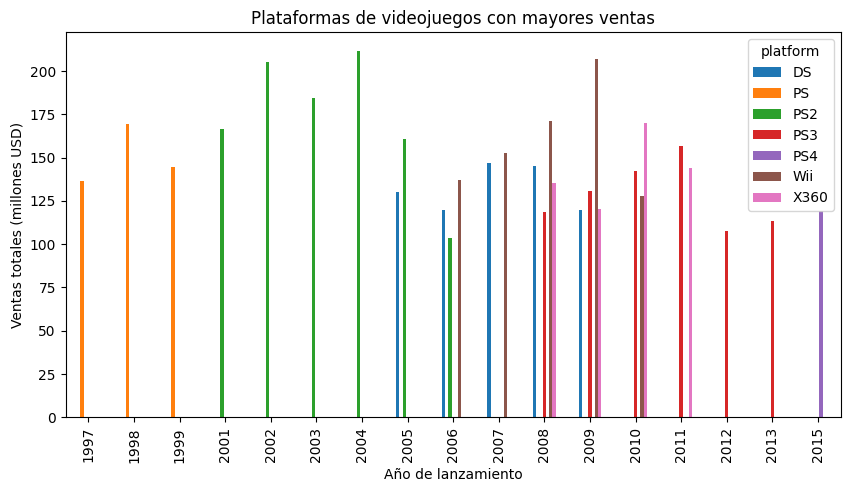

In [16]:
#elegir las plataformas con mayores ventas (ventas sobre 100 mill)
most_sellling_platforms = sales_per_platform[(sales_per_platform['total_sales'] > 100)] 


#crear una tabla dinámica con las plataformas con más ventas
platform_sales_pivot = most_sellling_platforms.pivot_table(index='year_of_release',
                                                           columns='platform' ,
                                                           values='total_sales',
                                                           aggfunc='sum'
                                                           )
                                                           
#crear una distribucion de los datos por cada año                                                       
platform_sales_pivot.plot(kind='bar',
                          xlabel='Año de lanzamiento',
                          ylabel='Ventas totales (millones USD)',
                          title= 'Plataformas de videojuegos con mayores ventas',
                          figsize=[10,5]
                          )

plt.show()

##### ¿Qué plataformas solían ser populares pero ahora ya no tienen ventas?

En primer lugar tenemos a la plataforma PS, que tuvo las mayores ventas hasta el año 99 y actualmente no tiene ventas. De alli le siguen las plataformas PS2, DS, Wii, X360 y PS3, que fueron las más populares hasta hace unos años y actualmente no se venden.

##### ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?

En promedio, las plataformas antiguan tardan 4,8 años aproximadamente en desaparecer, mientras que las nuevas tardan entre 1 y 2 años en aparecer.

En mi análisis determino que tomaré datos para los períodos correspondientes a los años de 2001 a 2015. 

Esto se debe a que al calcular el número de juegos lanzados cada año, noté que la mayor cantidad de videojuegos fué lanzada entre 2002 y 2011; por otra parte, las mayores ventas por plataforma se registraron enttre 1997 y 2015. De esta manera, tomaré mis datos en un período que cubra ambos resultados, siendo 2002 a 2016 mi elección.


#### ¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen?

De acuerdo con los análisis anteriores puedo decir que una de las plataformas que ha sido líder de ventas por muchos años es PS y está en constante crecimiento. De igual manera pienso que Wii y Xbox se mantienen constantes con buenas ventas en distintos periodos y también están creciendo.

Por otro parte, algunas plataformas parecen reducirse. Entre ellas se encuentran DS y PC.

<Axes: >

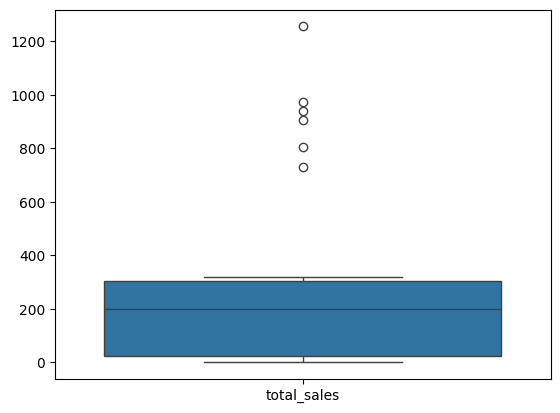

In [17]:
#crear diagrama de caja para ventas globales de todos los juegos por plataforma 

global_sales_platforms = games.groupby(['platform'])['total_sales'].sum().reset_index()


sns.boxplot(data = global_sales_platforms)


##### ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas?


Las ventas globales en promedio en varias plataformas rondan los 200 millones de dólares, sin embargo, en el diagrama se ven algunas diferencias significativas para otras plataformas, que se alejan bastante del promedio, superándolo con ventas que van desde los 600 hasta mas de 1.200.000 millones USD.

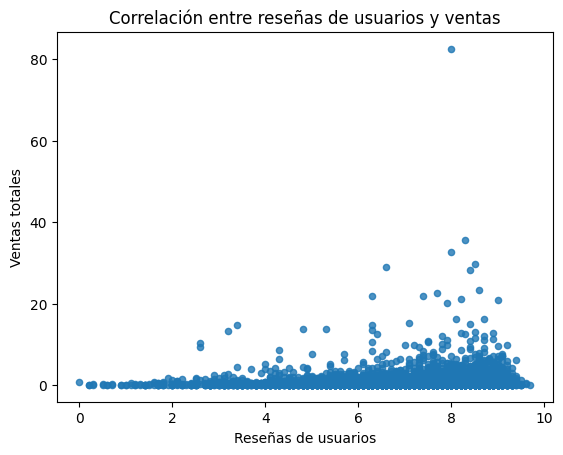

In [18]:
#crear gráfico de dispersión de correlacion entre las reseñas de los usuarios y las ventas totales

games.plot(x='user_score',
           y='total_sales',
           kind='scatter',
           alpha=0.8,
           title='Correlación entre reseñas de usuarios y ventas',
           xlabel='Reseñas de usuarios',
           ylabel='Ventas totales',
           )

plt.show()

In [19]:
#calcular el coeficiente de correlacion entre las ventas totales y las críticas de los usuarios
users_corr = games['user_score'].corr(games['total_sales'])

print(f'El coeficiente de correlación es:', users_corr)

El coeficiente de correlación es: 0.08817911987579136


De acuerdo con el resultado obtenido en el análisis previo, parece que las críticas de los usuarios no se correlacionan con las ventas de los videojuegos. El resultado es muy bajo como para pensar que una variable influye directamente en la otra.

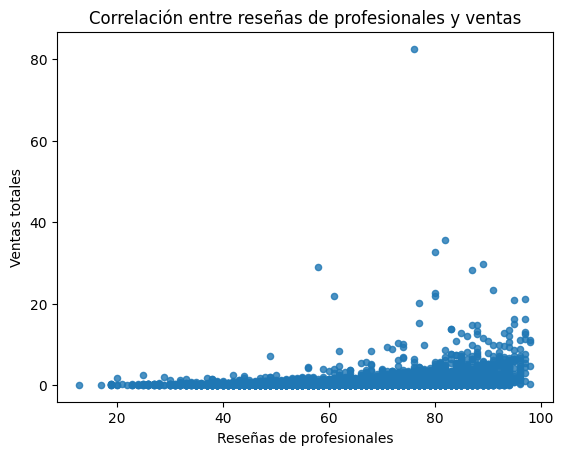

In [20]:
#crear gráfico de dispersión de correlacion entre las reseñas de los profesionales y las ventas totales

games.plot(x='critic_score', 
           y='total_sales',
           kind='scatter',
           alpha=0.8,
           title='Correlación entre reseñas de profesionales y ventas',
           xlabel='Reseñas de profesionales',
           ylabel='Ventas totales'
           )

plt.show()

In [21]:
#calcular el coeficiente de correlacion entre las ventas totales y las críticas de los profesionales
critic_corr = games['critic_score'].corr(games['total_sales'])

print(f'El coeficiente de correlación es:', critic_corr)

El coeficiente de correlación es: 0.24550668717736324


En el caso de las críticas de los profesionales, exite un poco más de correlación con las ventas de los videojuegos. Sin embargo, otra vez el resultado es muy bajo como para pensar que una variable influye directamente en la otra.

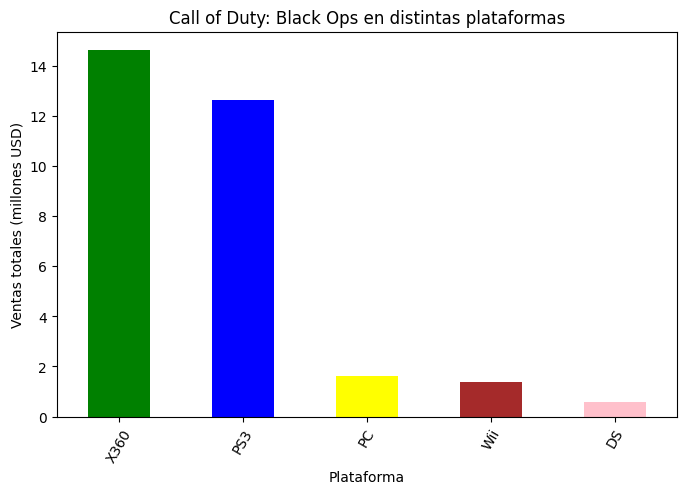

In [22]:
#crear una distribucion para comparar los juegos en distintas plataformas
platform_vs_platform = games[(games['name']== 'Call of Duty: Black Ops')][['name', 'platform', 'total_sales', 'year_of_release']]

colors = ['green', 'blue', 'yellow', 'brown', 'pink']        
platform_vs_platform.plot(kind='bar',
                          x='platform',
                          y='total_sales',
                          xlabel='Plataforma',
                          ylabel='Ventas totales (millones USD)',
                          title='Call of Duty: Black Ops en distintas plataformas',
                          color=colors,
                          rot=60,
                          legend=False,
                          figsize= [8, 5]
                          )

plt.show()

Tomé el juego Call of Duty: Black Ops para realizar una comparación de ventas en distintas plataformas. El resultado es significativo. Todas las plataformas lanzaron el juego en el mismo año, 2010, sin embargo las ventas de X360 constrastan enormemente con las de DS. Podríamos concluir que las ventas mejoran o empeoran dependiendo de la plataforma .

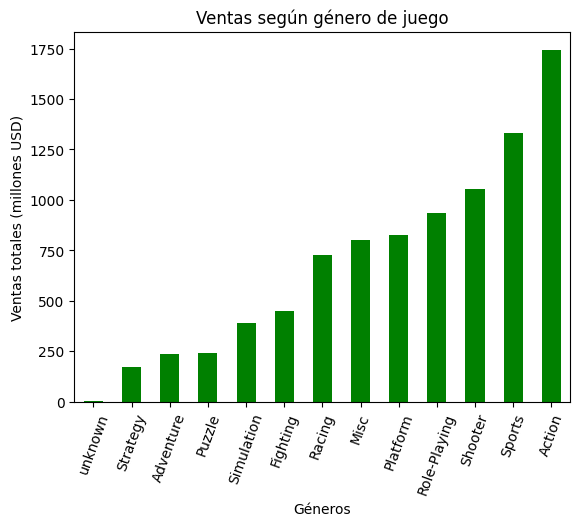

In [23]:
#crear una distribución de acuerdo con los géneros de los juegos y las ventas
genre_grp = games.groupby('genre')['total_sales'].sum().sort_values()

genre_grp.plot(kind='bar',
               xlabel='Géneros',
               ylabel='Ventas totales (millones USD)',
               title='Ventas según género de juego',
               rot=70,
               color='green'
               )

plt.show()

Luego de observar el gráfico, puedo generalizar un poco y decir que el género más rentable es el de acción, seguido por juegos de deportes. Por otro lado, juegos de estrategia, aventura y rompecabezas serían los menos rentables de todos. 


Finalmente, intuyo que mientras que las ventas de los videojuegos no están correlacionadas con las críticas de usuarios y profesionales, si tienen una fuerte relación con el género al que pertenecen. 

## 4. Perfil de usuario para cada región

In [24]:
#perfil de usuario para ventas en Japón

#ordenar el dataframe por las ventas en Japón, en orden descendente
jp_profile = games.sort_values('jp_sales', ascending=False)

#seleccionando las mejores ventas entre el año 2002 y 2016
jp_profile_games = jp_profile[(jp_profile['year_of_release'] >= 2002) & (jp_profile['year_of_release'] <=2016)]

#estableciendo el top 5 de las plataformas que vendieron mas en Japón 
jp_top_games = jp_profile_games[['name', 'platform', 'year_of_release', 'genre', 'jp_sales', 'critic_score', 'user_score', 'rating', 'total_sales']].reset_index()

jp_top_games.head()

,index,name,platform,year_of_release,genre,jp_sales,critic_score,user_score,rating,total_sales
0,6,New Super Mario Bros.,DS,2006,Platform,6.50,89.0,8.5,E,29.80
1,20,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,6.04,NaN,NaN,unknown,18.24
2,27,Pokemon Black/Pokemon White,DS,2010,Role-Playing,5.65,NaN,NaN,unknown,15.13
3,25,Pokemon Ruby/Pokemon Sapphire,GBA,2002,Role-Playing,5.38,NaN,NaN,unknown,15.84
4,43,Animal Crossing: Wild World,DS,2005,Simulation,5.33,86.0,8.7,E,12.14


In [25]:
#perfil de usuario para ventas en Europa

#ordenar el dataframe por las ventas en Europa, en orden descendente
eu_profile = games.sort_values('eu_sales', ascending=False)

#seleccionando las mejores ventas entre el año 2002 y 2016
eu_profile_games = eu_profile[(eu_profile['year_of_release'] >= 2002) & (eu_profile['year_of_release'] <=2016)]

#estableciendo el top 5 de las plataformas que vendieron mas en Europa 
eu_top_games = eu_profile_games[['name', 'platform', 'year_of_release', 'genre', 'eu_sales', 'critic_score', 'user_score', 'rating', 'total_sales']].reset_index()

eu_top_games.head()

,index,name,platform,year_of_release,genre,eu_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,28.96,76.0,8.0,E,82.54
1,2,Mario Kart Wii,Wii,2008,Racing,12.76,82.0,8.3,E,35.52
2,10,Nintendogs,DS,2005,Simulation,10.95,NaN,NaN,unknown,24.67
3,3,Wii Sports Resort,Wii,2009,Sports,10.93,80.0,8.0,E,32.77
4,19,Brain Age: Train Your Brain in Minutes a Day,DS,2005,Misc,9.20,77.0,7.9,E,20.14


In [26]:
#perfil de usuario para ventas en Norteamerica

#ordenar el dataframe por las ventas en Na, en orden descendente
na_profile = games.sort_values('na_sales', ascending=False)

#seleccionando las mejores ventas entre el año 2002 y 2016
na_profile_games = na_profile[(na_profile['year_of_release'] >= 2002) & (na_profile['year_of_release'] <=2016)]

#estableciendo el top 5 de las plataformas que vendieron mas en NA
na_top_games = na_profile_games[['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'critic_score', 'user_score', 'rating', 'total_sales']].reset_index()

na_top_games.head()

,index,name,platform,year_of_release,genre,na_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,76.0,8.0,E,82.54
1,2,Mario Kart Wii,Wii,2008,Racing,15.68,82.0,8.3,E,35.52
2,3,Wii Sports Resort,Wii,2009,Sports,15.61,80.0,8.0,E,32.77
3,14,Kinect Adventures!,X360,2010,Misc,15.00,61.0,6.3,E,21.82
4,8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,87.0,8.4,E,28.32


He creado un perfil de usuario para las cinco plataformas que tuvieron mejores ventas en el período comprendido del año 2002 hasta 2016, para las regiones de Japón, Europa y Norteamérica. 

Al analizar la información arrojada por cada región, puedo notar que las cuotas de mercado varían significativamente, en el siguiente orden: Norteamérica registra las mayores ventas; le sigue Europa con ventas un poco más bajas; finalmente, Japón muestra un cambio más significativo, registrando las ventas más bajas de las tres regiones. 


En cuanto a los géneros de videojuegos preferidos en cada región tenemos que Europa prefiere juegos de deportes, carreras, simulación y Misc; un poco parecido a Norteamérica, dondé prefieren juegos de deportes, carreras, Misc y plataforma. Marcando un poco de contraste, Japón prefiere juegos de plataforma, role-playing y simulación. (Todas las regiones muestran su preferencia de géneros de videojuegos en el mismo orden en que se escribieron los géneros).

#### Correlación entre las reseñas de los profesionales y las ventas de cada región

In [27]:
#calcular el coeficiente de correlacion entre las ventas de Japón y las reseñas de los profesionales
jp_critic_corr = jp_top_games['critic_score'].corr(jp_top_games['jp_sales'])

In [28]:
#calcular el coeficiente de correlacion entre las ventas de Europa y las reseñas de los profesionales
eu_critic_corr = eu_top_games['critic_score'].corr(eu_top_games['eu_sales'])

In [29]:
#calcular el coeficiente de correlacion entre las ventas de Norteamérica y las reseñas de los profesionales
na_critic_corr = na_top_games['critic_score'].corr(na_top_games['na_sales'])

In [30]:
print(f'El coeficiente de correlación en Japón es:', jp_critic_corr)
print()
print(f'El coeficiente de correlación en Europa es:', eu_critic_corr)
print()
print(f'El coeficiente de correlación en Norteamérica es:', na_critic_corr)

El coeficiente de correlación en Japón es: 0.13057727442249756

El coeficiente de correlación en Europa es: 0.21344706478944334

El coeficiente de correlación en Norteamérica es: 0.22694430087702194


Al calcular el coeficiente de correlación entre las reseñas de los profesionales y las ventas en cada una de las regiones (Japón, Europa y Norteamérica), me doy cuenta de que el nivel es muy bajo como para pensar que las reseñas influyen en las ventas. 

## 5. Prueba de hipótesis

A continuación le daré respuestas a dos hipótesis:


#### Hipótesis 1:

- Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.


In [ ]:
#calcular la calificacion promedio de usuarios de xbox one
xone_user_score = games[(games['platform'] == 'XOne')]['user_score']

#calcular la calificacion promedio de usuarios de PC
pc_user_score = games[(games['platform'] == 'PC')]['user_score']

#eliminar los valores ausentes
xone_user_score.dropna(inplace=True)
pc_user_score.dropna(inplace=True)

- Hipótesis nula: las calificaciones promedio son las mismas.

- Hipótesis alternativa: las calificaciones promedio son distintas.

Nivel de significancia: 0.1%.

In [32]:
#prueba de hipótesis 1

alpha= 0.01

#si el valor p es menor que alpha, rechazamos la hipótesis

results = st.ttest_ind(xone_user_score, pc_user_score, equal_var=False)

print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')


valor p: 4.935072360183574e-06
Rechazamos la hipótesis nula


#### Hipótesis 2:

- Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes. 

In [ ]:
#calcular la calificacion promedio de usuarios de géneros de acción
action_user_score = games[(games['genre'] == 'Action')]['user_score']

#calcular la calificacion promedio de usuarios de géneros de deporte
sports_user_score = games[(games['genre'] == 'Sports')]['user_score']

#eliminar los valores ausentes
action_user_score.dropna(inplace=True)
sports_user_score.dropna(inplace=True)


- Hipótesis nula: las calificaciones promedio son iguales.

- Hipótesis alternativa: las calificaciones promedio son diferentes.

Nivel de significancia: 0.1%.


In [34]:
#prueba de hipótesis 2

alpha= 0.01

#si el valor p es menor que alpha, rechazamos la hipótesis

results = st.ttest_ind(action_user_score, sports_user_score, equal_var=False)

print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')

valor p: 0.11483818791498286
No podemos rechazar la hipótesis nula


#### Respuestas de las hipótesis planteadas.

#### Hipótesis 1

En la primera hipótesis se planteó que las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.
Para poder darle respuesta, formulé una hipótesis nula que plantea que las calificaciones son iguales y una alternativa que plantea que las mismas son distintas. 

En mi prueba tuve como resultado el rechazo de mi hipótesis nula, por lo tanto, se podría determinar que, en efecto, las calificaciones promedio de los usuarios de ambas plataformas son distintas.

#### Hipótesis 2

En el caso de la segunda hipótesis, se planteó que las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.
En esta oportunidad, plateé una hipótesis nula que dice que las calificaciones de los usuarios son las mismas, y una hipótesis alternativa que establece que tales calificaciones son diferentes.

En mi segunda prueba, obtuve como resultado el rechazo de mi hipótesis alternativa. Por ende, se podría establecer que las calificaciones promedio de los usuarios en ambos géneros son iguales.
